# GOES and IBTrACS Data with Projections

Now that we've explored the GOES satellite data and the IBTrACS data in Python, let's put them both together. In order to do so, we'll have to obtain the projection data of the GOES imagery, project the IBTrACS latitudes/longitudes using the GOES projection data, and then overlay the track on the GOES imagery.

Rather than using the entirety of the IBTrACS data, we focus specifically on the track of [Hurricane Harvey in 2017](https://en.wikipedia.org/wiki/Hurricane_Harvey). This was a devastating storm that first made landfall in Texas. I chose this storm because I'm pretty familiar with it and know roughly what to expect for the imagery and the track.

## Import Modules

Let's first import the modules we need to run the code.

In [1]:
import pandas as pd
import xarray as xr
import requests
import netCDF4
import boto3
import matplotlib.pyplot as plt
import os
import datetime
import utils
from pyproj import Proj
from mpl_toolkits.basemap import Basemap
import numpy as np

## Retrieve IBTrACS Data

Now let's load up the IBTrACS data, as we did in a previous notebook, and then drill down on the track for Hurricane Harvey in 2017.

In [2]:
# Set the file path for the IBTrACS data
filePath = './data/ibtracs_NA.csv'

# Read the data from the CSV
df = pd.read_csv(filePath,low_memory=False,skiprows=range(1,2))

# Only keep a handful of columns
keepColumns = ['SID','SEASON','NUMBER','NAME','ISO_TIME',
               'NATURE','LAT','LON','WMO_WIND','WMO_PRES','TRACK_TYPE',
               'DIST2LAND','LANDFALL','IFLAG','STORM_SPEED','STORM_DIR']
df = df[keepColumns]

# Convert time strings to datetimes for better querying
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
df['SEASON'] = pd.to_numeric(df['SEASON'])
df['NUMBER'] = pd.to_numeric(df['NUMBER'])
df['LAT'] = pd.to_numeric(df['LAT'])
df['LON'] = pd.to_numeric(df['LON'])

# Keep only the Hurricane Harvey (2017) track
df = df[df['SEASON'] == 2017]
df = df[df['NAME'] == 'HARVEY']

# Show a preview
df.head(10)

SID  SEASON  NUMBER    NAME            ISO_TIME NATURE  \
117722  2017228N14314    2017      61  HARVEY 2017-08-16 06:00:00     DS   
117723  2017228N14314    2017      61  HARVEY 2017-08-16 09:00:00     DS   
117724  2017228N14314    2017      61  HARVEY 2017-08-16 12:00:00     DS   
117725  2017228N14314    2017      61  HARVEY 2017-08-16 15:00:00     DS   
117726  2017228N14314    2017      61  HARVEY 2017-08-16 18:00:00     DS   
117727  2017228N14314    2017      61  HARVEY 2017-08-16 21:00:00     DS   
117728  2017228N14314    2017      61  HARVEY 2017-08-17 00:00:00     DS   
117729  2017228N14314    2017      61  HARVEY 2017-08-17 03:00:00     DS   
117730  2017228N14314    2017      61  HARVEY 2017-08-17 06:00:00     TS   
117731  2017228N14314    2017      61  HARVEY 2017-08-17 09:00:00     TS   

            LAT      LON WMO_WIND WMO_PRES TRACK_TYPE  DIST2LAND LANDFALL  \
117722  13.7000 -45.8000       25     1013       main       1209     1157   
117723  13.7130 -46.5999                         main       1157     1109   
117724  13.7000 -47.4000       25     1010       main       1109     1067   
117725  13.6497 -48.2001                         main       1057     1018   
117726  13.6000 -49.0000       25     1009       main       1018      986   
117727  13.6074 -49.8148                         main        986      948   
117728  13.6000 -50.6000       25     1010       main        948      908   
117729  13.5222 -51.3150                         main        908      874   
117730  13.4000 -52.0000       25     1008       main        874      847   
117731  13.2422 -52.6851                         main        834      811   

                 IFLAG STORM_SPEED STORM_DIR  
117722  O_____________          16       271  
117723  P_____________          16       270  
117724  O_____________          16       268  
117725  P_____________          16       266  
117726  O_____________          16       268  
117727  P_____________          16       270  
117728  O_____________          15       267  
117729  P_____________          14       262  
117730  O_____________          14       258  
117731  P_____________          14       258

## Retrieve GOES16 Image

Now let's grab a GOES16 image corresponding to Hurricane Harvey. It made landfall in Texas around August 25, 2017, so we'll set the date for the image to be that day.

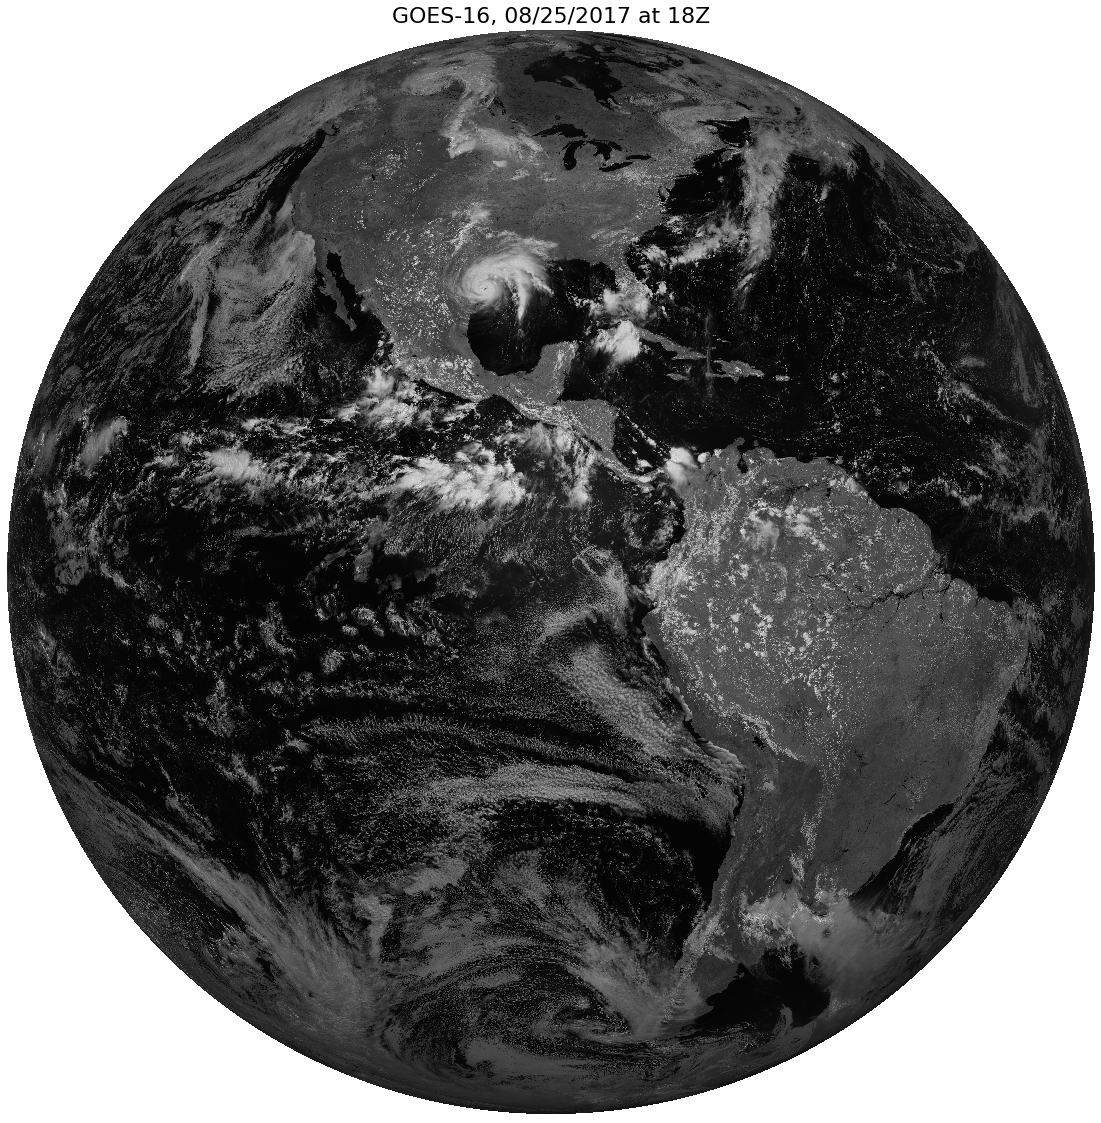

In [3]:
# Set image specific parameters
bucketName = 'noaa-goes16'
productName = 'ABI-L1b-RadF'
band = 3

# Set date of image
date = datetime.datetime(2017,8,25,18)
year = date.year
day = utils.day_of_year(date)
hour = date.hour

# Identify scan mode based on date
if date < datetime.datetime(2019,4,2,16):
    scanMode = "M3"
else:
    scanMode = "M6"

# Initialize S3 client with credentials
keyID,key = utils.read_aws_creds()
s3Client = boto3.client('s3',aws_access_key_id=keyID,aws_secret_access_key=key)

# Set the file prefix string
prefix = f'{productName}/{year}/{day:03.0f}/{hour:02.0f}/OR_{productName}-{scanMode}C{band:02.0f}'

# Get the keys from the S3 bucket
keys = utils.get_s3_keys(bucketName,s3Client,prefix)

# Selecting the first measurement taken within the hour
key = [key for key in keys][0] 

# Send a request to the bucket
resp = requests.get(f'https://{bucketName}.s3.amazonaws.com/{key}')

# Open the GOES 16 image
fileName = key.split('/')[-1].split('.')[0]
nc4 = netCDF4.Dataset(fileName,memory=resp.content)
store = xr.backends.NetCDF4DataStore(nc4)
ds = xr.open_dataset(store)

# Create plot
fig, ax = plt.subplots(figsize=(20,20));
ax.imshow(ds.Rad, cmap='gray');
ax.set_title('GOES-16, '+date.strftime("%m/%d/%Y")+" at "+str(hour)+"Z",fontsize=22);
ax.axis('off');

# Save figure
figFile = "GOES_East_"+date.strftime("%m%d%Y"+str(hour)+"Z")
plt.savefig(f'./images/{figFile}.png', dpi=300, facecolor='w', edgecolor='w')

## Overlay State and Country Borders with Basemap

Now let's experiment with projections. To make sure we've got the projection right, we start by overlaying the boundaries of states, countries, and coastlines on the GOES imagery. In order to do so, we need to get the projection of the GOES data. This information is stored in the netCDF metadata, primarily as attributes for the variable `goes_imager_projection`. So once we get the projection data, we'll load this into the base map, and then the borders should be easily drawn using the base map utilities.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


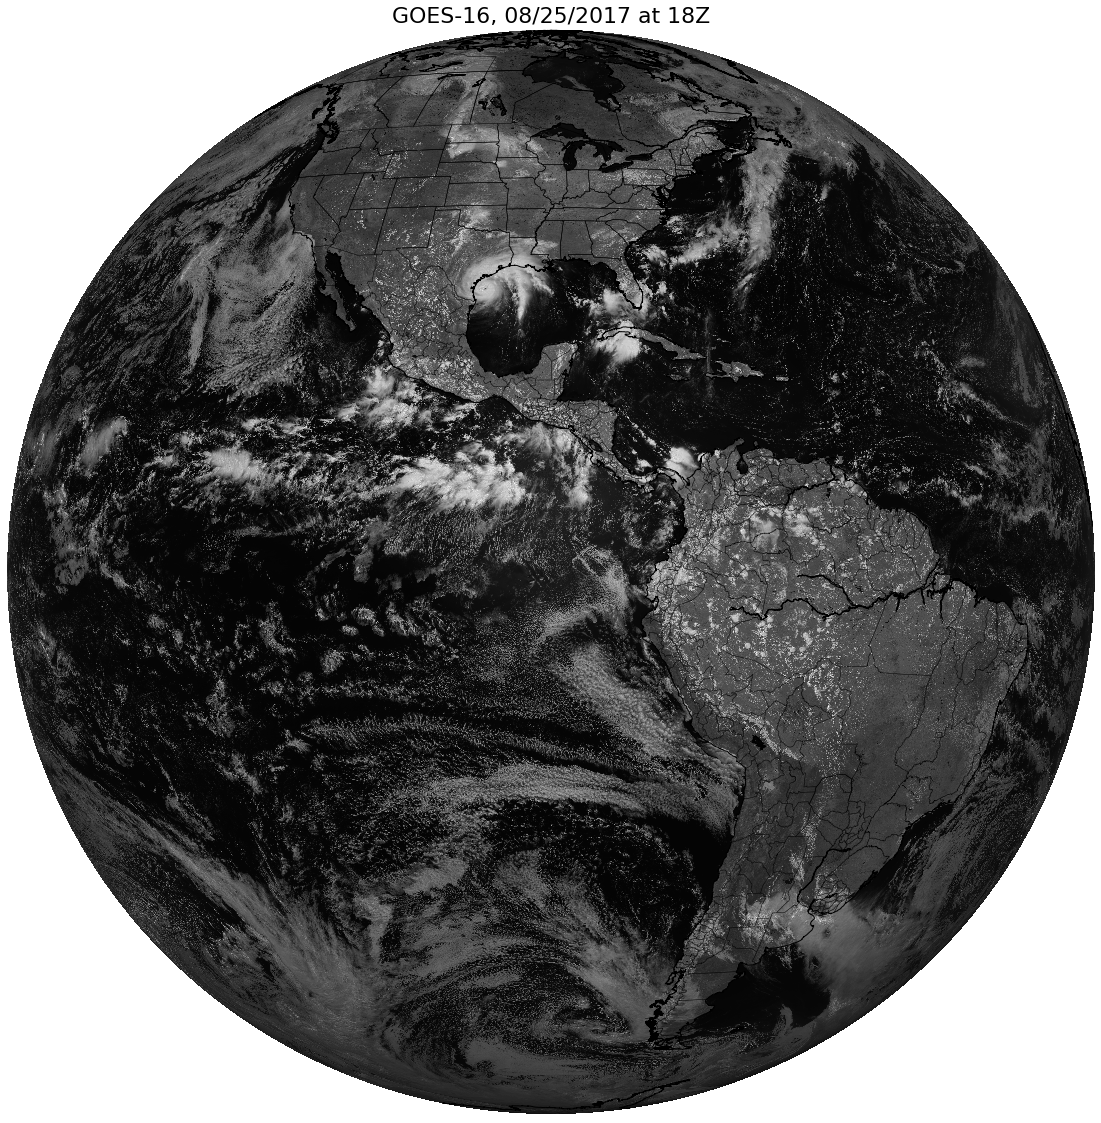

In [4]:
# Get dataset projection data
satHeight = ds.goes_imager_projection.perspective_point_height
satLon = ds.goes_imager_projection.longitude_of_projection_origin
satSweep = ds.goes_imager_projection.sweep_angle_axis
majorMinorAxes = (ds.goes_imager_projection.semi_major_axis,ds.goes_imager_projection.semi_minor_axis)

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
x = ds.variables['x'][:] * satHeight
y = ds.variables['y'][:] * satHeight

# Set the geostationary projection
m = Basemap(projection='geos', lon_0=satLon,
            rsphere=majorMinorAxes,
            resolution='i', area_thresh=5000,
            llcrnrx=x.min(),llcrnry=y.min(),
            urcrnrx=x.max(),urcrnry=y.max())

# Create the plot
plt.figure(figsize=(20,20))
m.imshow(np.flipud(ds.Rad), cmap='gray'); 
m.drawcoastlines();
m.drawcountries();
m.drawstates();
plt.axis('off');
plt.title('GOES-16, '+date.strftime("%m/%d/%Y")+" at "+str(hour)+"Z",fontsize=22);

## Overlay IBTRaCS Data

Now that we can see the projection is working properly, let's add the Hurricane Harvey track as of August 25, 2017 at 18Z. We first need to grab the latitude longitudes from the IBTRaCS data. We can then use `pyproj.Proj` to convert longitudes and latitudes to the $x$ and $y$ space of the projected GOES image.

I don't fully understand this part, but the netCDF $x$ and $y$ arrays go symmetrically from -5434394 to 5434394, but the basemap seems to span from 0 to 10868788. So to properly draw the tracks, we'll need to add 5434394 to the output $x$ and $y$ of `pyproj.Proj` for each longitude and latitude in the track.

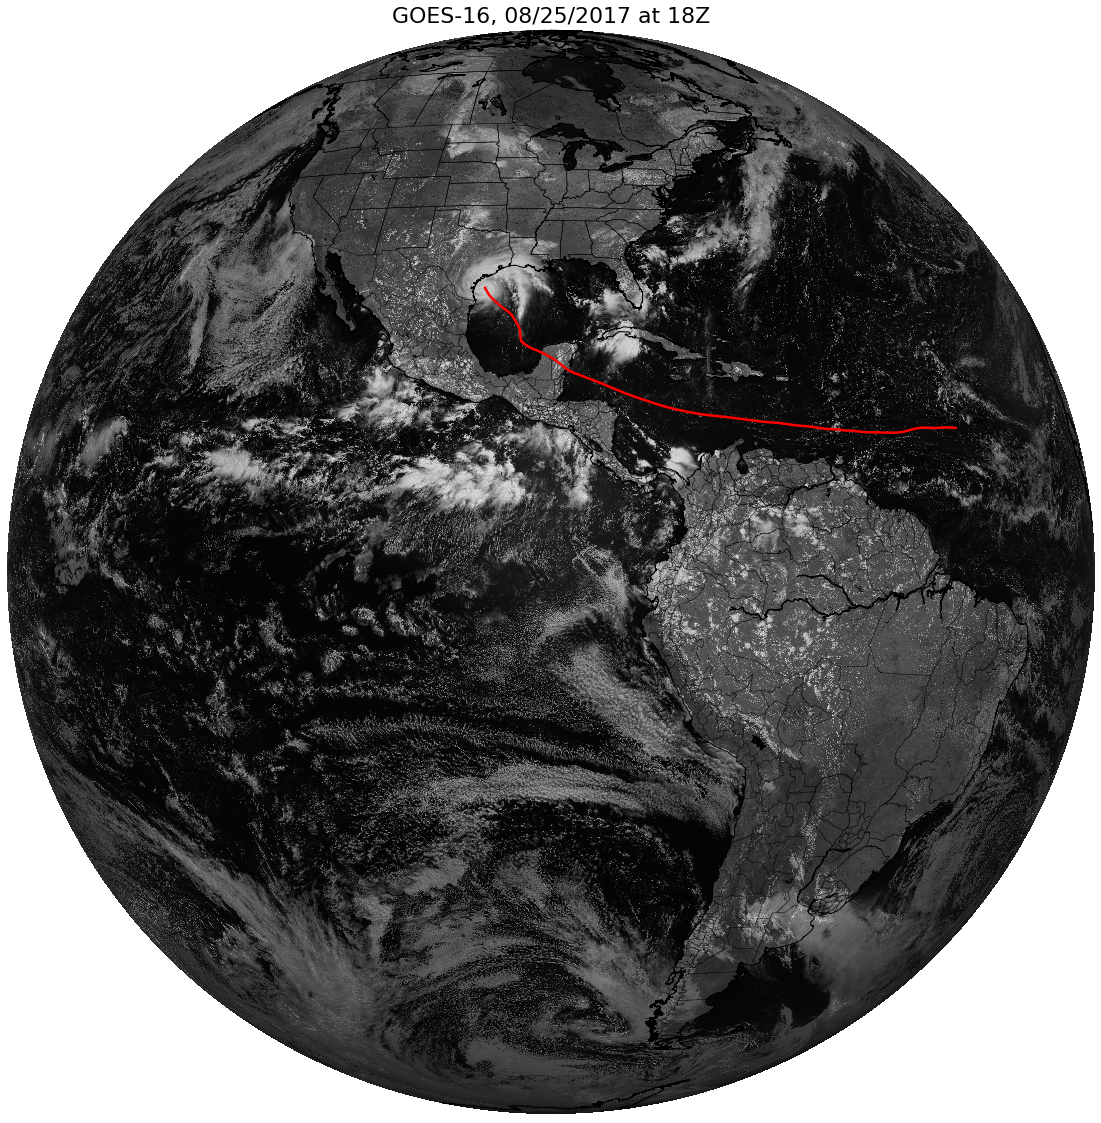

In [5]:
# Get the latitudes/longitudes of the Hurricane Harvey track data
df = df[df['ISO_TIME']<=date]
latList = list(df['LAT'])
lonList = list(df['LON'])

# Create a pyproj geostationary map object
p = Proj(proj='geos', h=satHeight, lon_0=satLon, sweep=satSweep)

# Convert lon/lat to x/y
xList,yList = p(lonList,latList)

# Projected coordinates are negative, but matplotlib starts at 0. 
# Add half of the image width and height to properly draw on map
xList = [point+float(x.max()) for point in xList]
yList = [point+float(y.max()) for point in yList]

# Add track to the basemap plot
plt.figure(figsize=(20,20))
m.imshow(np.flipud(ds.Rad), cmap='gray'); 
m.drawcoastlines();
m.drawcountries();
m.drawstates();
m.plot(xList,yList,linewidth=2.5,color='r')
plt.axis('off');
plt.title('GOES-16, '+date.strftime("%m/%d/%Y")+" at "+str(hour)+"Z",fontsize=22);